In [1]:
cd

/Users/keith_tetrad


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bioservices import QuickGO
quickgo = QuickGO()

In [3]:
import matplotlib.pyplot as plt

In [4]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('expand_frame_repr', False)


In [5]:
apms_data = pd.DataFrame(pd.read_csv('kw_dms/nevan analysis/1-s2.0-S0092867423009157-mmc3(1).csv', delimiter=','))

In [6]:
# Filter for rows where any of the specified columns is True
flag_apms_data = apms_data.loc[apms_data[['flag_SaintandMist_final', 'flag_Saint_final', 'flag_SaintandMistorNatureSaint_final']].any(axis=1)].reset_index(drop=True)

In [7]:
def go_term(go_id):
    # Define parameters
    taxon_id = "9606"  # Taxonomy ID for Homo sapiens
    go_id = go_id # GO term
    
    # Fetch annotations
    annotations = quickgo.Annotation(taxonId=taxon_id, goId=go_id)

    # Extract results
    results = annotations['results']

    # Extract gene products using 'symbol' key
    gene_products = [result['symbol'] for result in results if result.get('symbol')]

    # Extract gene products using 'symbol' key and add them to a list
    gene_products = [result['symbol'] for result in results if result.get('symbol')]

    # Convert the list to a set to remove duplicates, and then back to a list
    unique_gene_products = list(set(gene_products))
    
    return unique_gene_products

def go_term_mask(mask):

    # Create a boolean mask
    mask = flag_apms_data['PreyGene'].apply(lambda x: any(word in x for word in mask))
    
    return flag_apms_data[mask]

In [8]:
#ATP-dependent protein folding chaperone
GO_0140662 = go_term('GO:0140662')
ATP = go_term_mask(GO_0140662)

#protein folding in endoplasmic reticulum
GO_0034975 = go_term('GO:0034975')
ER = go_term_mask(GO_0034975)

#protein folding chaperone
GO_0044183 = go_term('GO:0044183')
all_chaps = go_term_mask(GO_0044183)

In [9]:
# Group by the 'ViralProtein' and aggregate unique values in 'PreyGene'
grouped = ATP.groupby('ViralProtein')['PreyGene'].unique()

# Group by both 'variant' and 'ViralProtein', then aggregate unique values in 'PreyGene'
grouped_byvariant = ER.groupby(['ViralProtein','Variant'])['PreyGene'].unique()

In [10]:
#extract a list of unique PreyGenes
unique_ER = ER['PreyGene'].unique()
unique_ATP = ATP['PreyGene'].unique()
unique_all_chaps = all_chaps['PreyGene'].unique()

# Combine and find unique values
combined_unique = np.concatenate((unique_ER, unique_ATP, unique_all_chaps))
unique_chaps = np.unique(combined_unique)

chunk_size = 10000  # Adjust based on your memory constraints
normal_tissue_data = pd.DataFrame()  # Initialize an empty DataFrame for the filtered data
rna_single_cell_data = pd.DataFrame()

for chunk in pd.read_csv('kw_dms/nevan analysis/normal_tissue.tsv', sep='\t', chunksize=chunk_size):
    # Filter the chunk
    filtered_chunk = chunk[chunk['Gene name'].isin(unique_chaps)]
    # Append the filtered chunk to the DataFrame
    normal_tissue_data = pd.concat([normal_tissue_data, filtered_chunk])

for chunk in pd.read_csv('kw_dms/nevan analysis/rna_single_cell_type.tsv', sep='\t', chunksize=chunk_size):
    # Filter the chunk
    filtered_chunk = chunk[chunk['Gene name'].isin(unique_chaps)]
    # Append the filtered chunk to the DataFrame
    rna_single_cell_data = pd.concat([rna_single_cell_data, filtered_chunk])
    

In [11]:
unique_tissue_cells = normal_tissue_data.groupby('Tissue')['Cell type'].unique()
unique_RNA_cells = rna_single_cell_data['Cell type'].unique()

# for tissue, cell_types in unique_tissue_cells.items():
#     print(f"{tissue}: {', '.join(cell_types)}")
#     print('\n')
    
# with open('tissue_cell_types.txt', 'w') as file:
#     for tissue, cell_types in unique_tissue_cells.items():
#         file.write(f"{tissue}: {', '.join(cell_types)}\n")
#         file.write('\n')  # This adds an empty line after each tissue


In [12]:
tissue_cell_types = {
    'bronchus': ['respiratory epithelial cells', 'basal cells', 'Basal respiratory cells', 'Ciliated cells', 'ciliated cells (cell body)', 'ciliated cells (cilia axoneme)', 'ciliated cells (ciliary rootlets)', 'ciliated cells (tip of cilia)', 'goblet cells'],
    'kidney': ['cells in tubules', 'collecting ducts'],
    'lung': ['alveolar cells type I', 'alveolar cells type II', 'endothelial cells', 'alveolar cells'],
    'pancreas': ['exocrine glandular cells', 'pancreatic endocrine cells'],
    'skin': ['Basal keratinocytes', 'Basal squamous epithelial cells']
}

# Filter for only tissue/cell type combinations
def filter_combinations(row):
    tissue = row['Tissue']
    cell_type = row['Cell type']
    return cell_type in tissue_cell_types.get(tissue, [])

# Filter the DataFrame
tissue_SARS_filtered = normal_tissue_data[normal_tissue_data.apply(filter_combinations, axis=1)].reset_index(drop=True)

# Aggregate all unique cell types from the dictionary
all_cell_types = set()
for cell_types in tissue_cell_types.values():
    all_cell_types.update(cell_types)

# Cleaning up cell type names (some of this may not be biologically correct)
replacements = {
    'Alveolar cells type 1': 'alveolar cells type I',
    'Alveolar cells type 2': 'alveolar cells type II',
    'Collecting duct cells': 'collecting ducts',
    'Endothelial cells': 'endothelial cells',
    'Exocrine glandular cells': 'exocrine glandular cells',
    'Pancreatic endocrine cells': 'pancreatic endocrine cells'
}
rna_single_cell_data['Cell type'] = rna_single_cell_data['Cell type'].replace(replacements)

# Filter rna_single_cell_data based on the cell types
rna_single_cell_SARS_filtered = rna_single_cell_data[rna_single_cell_data['Cell type'].isin(all_cell_types)].reset_index(drop=True)


In [13]:
# Group by the 'ViralProtein' and aggregate unique values in 'PreyGene'
grouped = ER.groupby('ViralProtein')['PreyGene'].unique()
grouped

ViralProtein
E                                                                       [CANX]
M                                                                 [CANX, VAPA]
N                                                       [HSPA5, HSP90B1, CANX]
S                                           [HSPA5, CANX, P4HB, HSP90B1, CALR]
nsp12                                                                   [CANX]
nsp13                                                          [P4HB, HSP90B1]
nsp2                                                             [HSPA5, CANX]
nsp3                    [HSP90B1, CANX, P4HB, HSPA5, CALR, DNAJC3, EMC1, EMC3]
nsp4                                                             [HSPA5, CANX]
nsp6                                                                    [CANX]
orf3a                                                            [VAPA, HSPA5]
orf7a                                                             [P4HB, CANX]
orf7b                                  

protein immunohistochemistry data
                Gene Gene name    Tissue                   Cell type         Level Reliability
118  ENSG00000179218      CALR    kidney            cells in tubules          High    Enhanced
119  ENSG00000179218      CALR      lung       alveolar cells type I  Not detected    Enhanced
120  ENSG00000179218      CALR      lung      alveolar cells type II        Medium    Enhanced
121  ENSG00000179218      CALR      lung           endothelial cells  Not detected    Enhanced
122  ENSG00000179218      CALR  pancreas    exocrine glandular cells          High    Enhanced
123  ENSG00000179218      CALR  pancreas  pancreatic endocrine cells        Medium    Enhanced


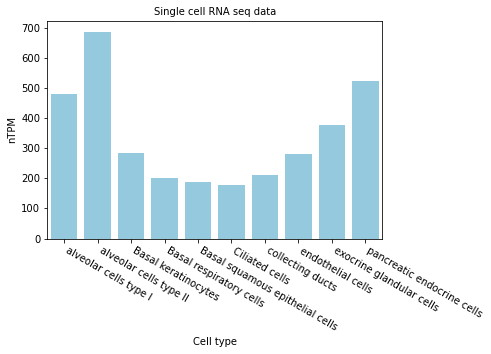

In [14]:
# Define the specific gene you are interested in
specific_gene = 'CALR'  # Replace with the actual gene identifier

# Filter the DataFrame for the specific gene
specific_gene_tissue = tissue_SARS_filtered[tissue_SARS_filtered['Gene name'] == specific_gene]
specific_gene_rna = rna_single_cell_SARS_filtered[rna_single_cell_SARS_filtered['Gene name'] == specific_gene]
# Print the results
print('protein immunohistochemistry data')
print(specific_gene_tissue)

# Create the barplot with a uniform color
sns.barplot(data=specific_gene_rna, x='Cell type', y='nTPM', color='skyblue')
plt.xticks(rotation=-30, ha='left')
plt.title('Single cell RNA seq data', fontsize=10)

plt.show()

In [ ]:
#pull rnaseq data from angelas work here: https://elifesciences.org/articles/38795/figures#fig2s1